In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import scipy
import sys
import time

In [2]:
hdf_ = h5py.File('/project2/chihway/data/decade/metacal_test_20230427.hdf')

<KeysViewHDF5 ['Ncutouts_raw', 'badfrac', 'ccdnum', 'dec', 'id', 'mcal_T_1m', 'mcal_T_1p', 'mcal_T_2m', 'mcal_T_2p', 'mcal_T_noshear', 'mcal_T_ratio_1m', 'mcal_T_ratio_1p', 'mcal_T_ratio_2m', 'mcal_T_ratio_2p', 'mcal_T_ratio_noshear', 'mcal_flags', 'mcal_flux_1m', 'mcal_flux_1p', 'mcal_flux_2m', 'mcal_flux_2p', 'mcal_flux_err_1m', 'mcal_flux_err_1p', 'mcal_flux_err_2m', 'mcal_flux_err_2p', 'mcal_flux_err_noshear', 'mcal_flux_noshear', 'mcal_g_1m', 'mcal_g_1p', 'mcal_g_2m', 'mcal_g_2p', 'mcal_g_cov_1m', 'mcal_g_cov_1p', 'mcal_g_cov_2m', 'mcal_g_cov_2p', 'mcal_g_cov_noshear', 'mcal_g_noshear', 'mcal_psf_T_noshear', 'mcal_psf_g_noshear', 'mcal_s2n_1m', 'mcal_s2n_1p', 'mcal_s2n_2m', 'mcal_s2n_2p', 'mcal_s2n_noshear', 'ra', 'x', 'x_exp', 'y', 'y_exp']>


In [3]:
len(hdf_['ra'])

111596425

In [11]:
%%time
idx = np.arange(len(hdf_['ra']))

CPU times: user 116 ms, sys: 577 ms, total: 693 ms
Wall time: 690 ms


In [72]:
%%time
N = int(1e3) #Get a subset N number of galaxies from full file. This is just so you read out small subset for now. The file takes a while to load so better to start small (we're trying to fix loading speed).
r_idx = np.sort(np.random.choice(idx, size=N, replace=False))

CPU times: user 6.62 s, sys: 641 ms, total: 7.26 s
Wall time: 7.23 s


In [73]:
%%time
idx_mask = np.isin(idx, r_idx)

CPU times: user 7.36 s, sys: 6.8 s, total: 14.2 s
Wall time: 14.2 s


In [74]:
%%time
with h5py.File('/project2/chihway/data/decade/metacal_test_20230427.hdf') as f:
    
    flux_r, flux_i, flux_z = np.array(f['mcal_flux_noshear'][idx_mask]).T
    flux_err_r, flux_err_i, flux_err_z = np.array(f['mcal_flux_err_noshear'][idx_mask]).T
    mag_r = 30 - 2.5*np.log10(flux_r)
    mag_i = 30 - 2.5*np.log10(flux_i)
    mag_z = 30 - 2.5*np.log10(flux_z)

    mcal_pz_mask = ((mag_i < 23.5) & (mag_i > 18) & 
                    (mag_r < 26)   & (mag_r > 15) & 
                    (mag_z < 26)   & (mag_z > 15) & 
                    (mag_r - mag_i < 4)   & (mag_r - mag_i > -1.5) & 
                    (mag_i - mag_z < 4)   & (mag_i - mag_z > -1.5))

    SNR     = np.array(f['mcal_s2n_noshear'][:N])
    T_ratio = np.array(f['mcal_T_ratio_noshear'][:N])
    T       = np.array(f['mcal_T_noshear'][:N])
    flags   = np.array(f['mcal_flags'][:N])
    
    g1, g2  = np.array(f['mcal_g_noshear'][:N]).T

    #Metacal cuts based on DES Y3 ones (from here: https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)
    SNR_Mask   = (SNR > 10) & (SNR < 1000)
    Tratio_Mask= T_ratio > 0.5
    T_Mask     = T < 10
    Flag_Mask  = flags == 0

    Other_Mask = np.invert((T > 2) & (SNR < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))

    Mask = mcal_pz_mask & SNR_Mask & Tratio_Mask & T_Mask & Flag_Mask & Other_Mask
    
    #These are the fluxes with all metacal cuts applied
    flux_r = flux_r[Mask]
    flux_i = flux_i[Mask]
    flux_z = flux_z[Mask]
    flux_err_r = flux_err_r[Mask]
    flux_err_i = flux_err_i[Mask]
    flux_err_z = flux_err_z[Mask]

CPU times: user 232 ms, sys: 170 ms, total: 402 ms
Wall time: 38.5 s


/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log10


In [68]:
%%time
N=int(1e6)
with h5py.File('/project2/chihway/data/decade/metacal_test_20230427.hdf') as f:
    
    flux_r_, flux_i_, flux_z_ = np.array(f['mcal_flux_noshear'][:N]).T
    flux_err_r_, flux_err_i_, flux_err_z_ = np.array(f['mcal_flux_err_noshear'][:N]).T
    mag_r = 30 - 2.5*np.log10(flux_r_)
    mag_i = 30 - 2.5*np.log10(flux_i_)
    mag_z = 30 - 2.5*np.log10(flux_z_)

    mcal_pz_mask = ((mag_i < 23.5) & (mag_i > 18) & 
                    (mag_r < 26)   & (mag_r > 15) & 
                    (mag_z < 26)   & (mag_z > 15) & 
                    (mag_r - mag_i < 4)   & (mag_r - mag_i > -1.5) & 
                    (mag_i - mag_z < 4)   & (mag_i - mag_z > -1.5))

    SNR     = np.array(f['mcal_s2n_noshear'][:N])
    T_ratio = np.array(f['mcal_T_ratio_noshear'][:N])
    T       = np.array(f['mcal_T_noshear'][:N])
    flags   = np.array(f['mcal_flags'][:N])
    
    g1, g2  = np.array(f['mcal_g_noshear'][:N]).T

    #Metacal cuts based on DES Y3 ones (from here: https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)
    SNR_Mask   = (SNR > 10) & (SNR < 1000)
    Tratio_Mask= T_ratio > 0.5
    T_Mask     = T < 10
    Flag_Mask  = flags == 0

    Other_Mask = np.invert((T > 2) & (SNR < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))

    Mask = mcal_pz_mask & SNR_Mask & Tratio_Mask & T_Mask & Flag_Mask & Other_Mask
    
    #These are the fluxes with all metacal cuts applied
    flux_r_ = flux_r_[Mask]
    flux_i_ = flux_i_[Mask]
    flux_z_ = flux_z_[Mask]
    flux_err_r_ = flux_err_r_[Mask]
    flux_err_i_ = flux_err_i_[Mask]
    flux_err_z_ = flux_err_z_[Mask]

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


CPU times: user 1.5 s, sys: 12.2 s, total: 13.7 s
Wall time: 16.2 s


/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log10


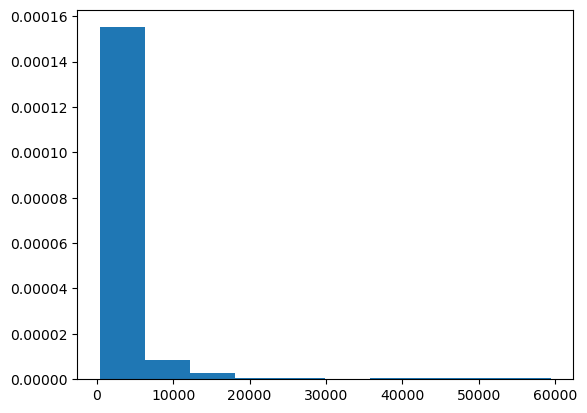

In [75]:
ab = plt.hist(flux_i, density=True)

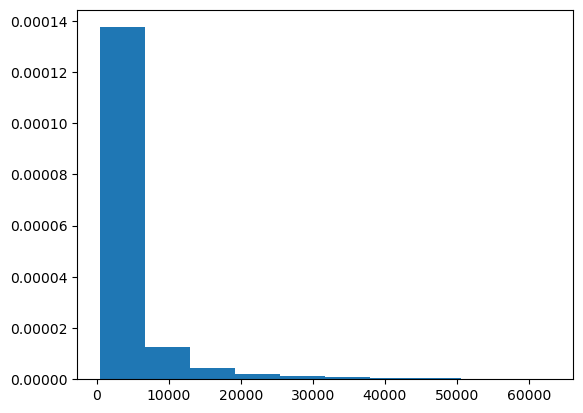

In [69]:
dc= plt.hist(flux_i_, density=True);

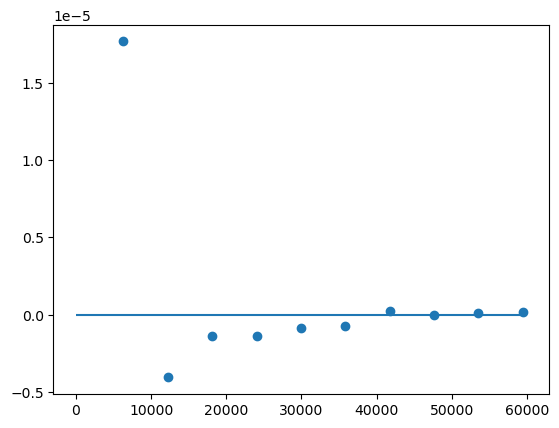

In [76]:
plt.scatter(ab[1][1:], ab[0]-dc[0])
plt.hlines(0, xmin=0, xmax=6e4)

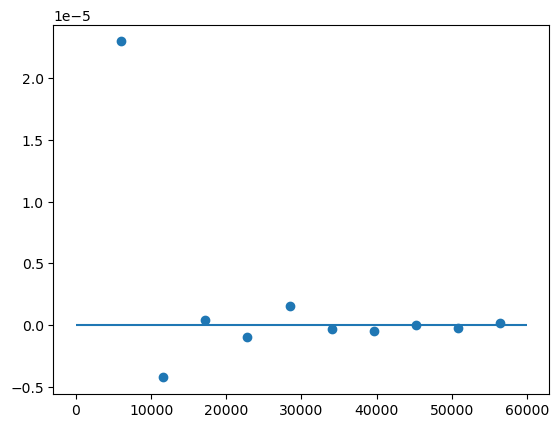

In [71]:
plt.scatter(ab[1][1:], ab[0]-dc[0])
plt.hlines(0, xmin=0, xmax=6e4)

In [15]:
flux_r

array([1341.07717556, 1045.09764575,  720.1753726 , ...,  682.80793806,
        432.23399329,  364.33226537])

In [16]:
np.zeros(int(1e8+3e5+1e6+1e3+2e4+3e2+4+7e1+6e7)).size

161321374

In [16]:
metacal_test['ra'], metacal_test['dec']

(<HDF5 dataset "ra": shape (111596425,), type "<f8">,
 <HDF5 dataset "dec": shape (111596425,), type "<f8">)

In [18]:
i=1
data_i = pd.read_csv('/project2/chihway/raulteixeira/data/bdf_photometry/dr3_1_1_bdf_0000%.2d.csv.gz'%i)

In [19]:
data_i

,Unnamed: 0,BDF_FLUX_ERR_G,BDF_FLUX_ERR_I,BDF_FLUX_ERR_R,BDF_FLUX_ERR_Z,BDF_FLUX_G,BDF_FLUX_I,BDF_FLUX_R,BDF_FLUX_Z,BDF_MAG_ERR_G,...,BDF_MAG_Z,BDF_S2N,BDF_T,BDF_T_ERR,BDF_T_RATIO,COADD_OBJECT_ID,DEC,RA,TILENAME,index
0,0,45.453359,131.797517,88.905316,166.633120,711.274688,894.056308,1041.800221,1256.858374,0.069383,...,22.251784,27.011140,0.138749,0.075012,0.115182,7102487092,27.507381,151.692954,b'DES1006+2751',0
1,1,29.377138,97.753053,59.315343,120.839489,250.862504,1331.462758,925.768139,1700.058381,0.127145,...,21.923840,31.202110,0.117498,0.046870,0.097531,7102487166,27.505418,151.195001,b'DES1006+2751',1
2,2,37.125305,102.701838,63.032921,131.678172,125.252352,607.613816,280.996600,631.930647,0.321817,...,22.998326,11.189171,0.093982,0.127729,0.080385,7102486722,27.513886,151.570765,b'DES1006+2751',2
3,3,36.196797,176.300175,69.087365,228.716165,146.453923,1760.637821,496.761256,3660.526013,0.268345,...,21.091141,31.774227,0.701004,0.194874,0.561435,7102485857,27.527388,151.475124,b'DES1006+2751',3
4,4,29.677488,110.458530,53.500550,103.765793,446.980398,964.367757,780.893278,1109.955551,0.072088,...,22.386736,28.065958,0.012088,0.031021,0.009688,7102487183,27.505770,151.486737,b'DES1006+2751',4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2489995,2489995,61.194161,168.974332,111.674002,255.938919,355.283073,1054.508274,627.523787,1351.431416,0.187008,...,22.173015,17.009415,1.978954,0.953786,2.181873,7101741628,15.004017,151.755157,b'DES1006+1500',2489995
2489996,2489996,29.413110,70.111455,51.581727,124.910952,1691.580515,2942.649602,2457.680337,2900.870713,0.018879,...,21.343679,101.318425,0.035240,0.009490,0.038142,7101738395,15.067651,151.383420,b'DES1006+1500',2489996
2489997,2489997,45.720489,165.180781,107.600376,227.231037,8619.825728,43717.025193,27549.581169,57671.541540,0.005759,...,18.097596,828.605412,2.388564,0.045883,2.669203,7139701007,8.217957,159.174737,b'DES1037+0752',2489997
2489998,2489998,77.099693,141.414179,121.252485,225.906804,3351.785894,5725.242211,4944.412963,6356.856070,0.024975,...,20.491894,98.170237,3.763813,0.233884,4.594762,7139703378,8.171689,159.594604,b'DES1037+0752',2489998


In [ ]:
for i in range(1,50):
    data_i = pd.read_csv('/project2/chihway/raulteixeira/data/bdf_photometry/dr3_1_1_bdf_0000%.2d.csv.gz'%i)
    r, i, z = data_i['']
    metacal_mask = 